In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import math

In [17]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import os
from torch.optim import *
os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [18]:
 path = untar_data(URLs.CIFAR)
    

In [28]:
data = (ImageList.from_folder(path)
       .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(),size = 32)
       ).databunch(bs = 64).normalize(imagenet_stats)
 

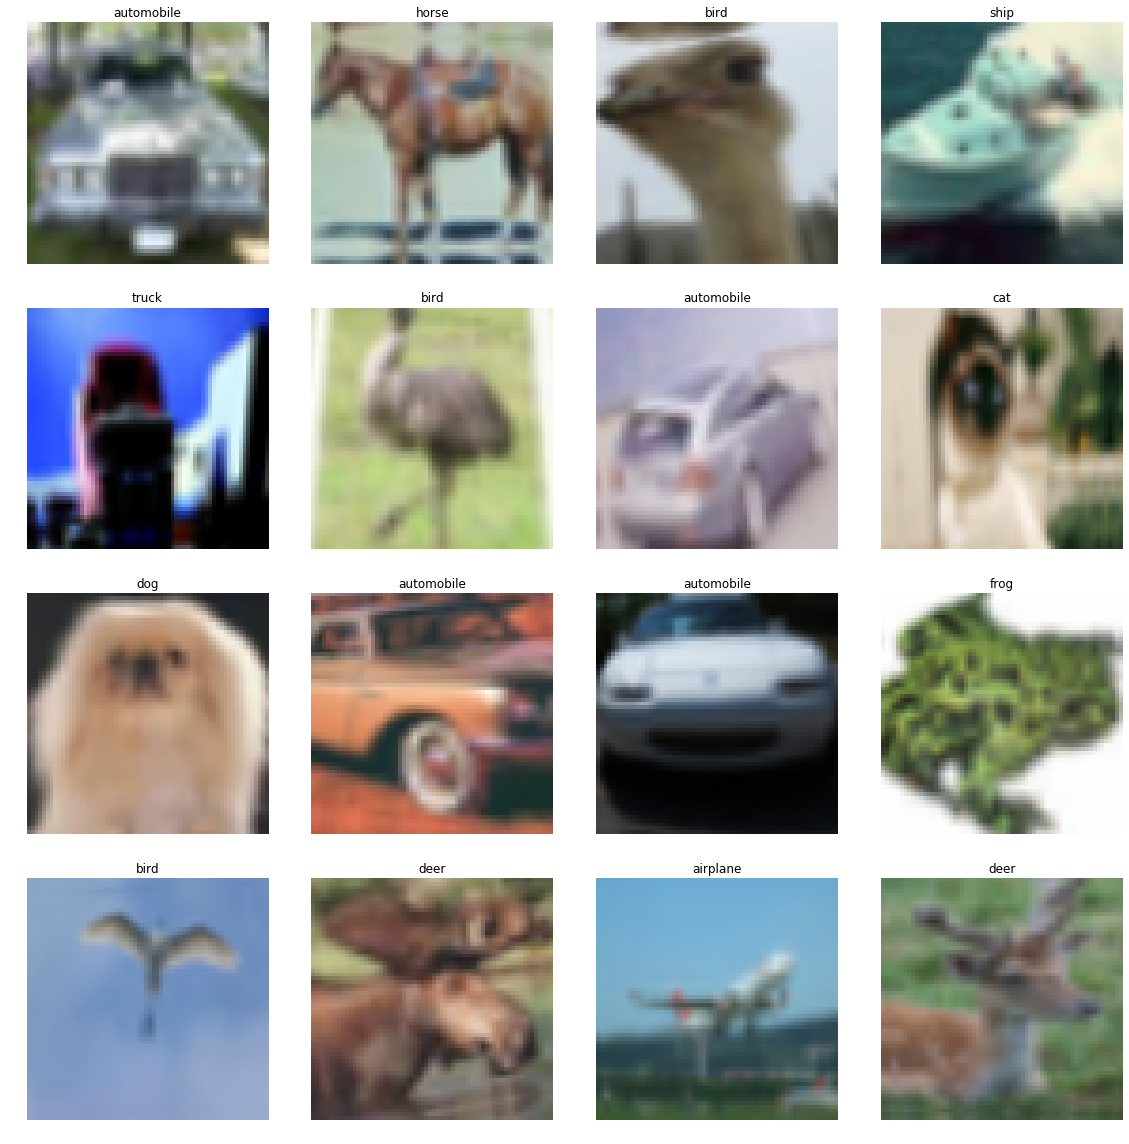

In [10]:
data.show_batch(4)
 

In [11]:
data.c
 

10

In [12]:
learn = None
gc.collect()

31441

In [33]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True),
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True),
    )


def channel_shuffle(x, groups):
    batchsize, num_channels, height, width = x.data.size()

    channels_per_group = num_channels // groups

    # reshape
    x = x.view(batchsize, groups, channels_per_group, height, width)

    x = torch.transpose(x, 1, 2).contiguous()

    # flatten
    x = x.view(batchsize, -1, height, width)

    return x


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, benchmodel):
        super(InvertedResidual, self).__init__()
        self.benchmodel = benchmodel
        self.stride = stride
        assert stride in [1, 2]

        oup_inc = oup // 2

        if self.benchmodel == 1:
            # assert inp == oup_inc
            self.banch2 = nn.Sequential(
                # pw
                nn.Conv2d(oup_inc, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(oup_inc, oup_inc, 3, stride, 1, groups=oup_inc, bias=False),
                nn.BatchNorm2d(oup_inc),
                # pw-linear
                nn.Conv2d(oup_inc, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.ReLU(inplace=True),
            )
        else:
            self.banch1 = nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                # pw-linear
                nn.Conv2d(inp, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.ReLU(inplace=True),
            )

            self.banch2 = nn.Sequential(
                # pw
                nn.Conv2d(inp, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(oup_inc, oup_inc, 3, stride, 1, groups=oup_inc, bias=False),
                nn.BatchNorm2d(oup_inc),
                # pw-linear
                nn.Conv2d(oup_inc, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.ReLU(inplace=True),
            )

    @staticmethod
    def _concat(x, out):
        # concatenate along channel axis
        return torch.cat((x, out), 1)

    def forward(self, x):
        if 1 == self.benchmodel:
            x1 = x[:, : (x.shape[1] // 2), :, :]
            x2 = x[:, (x.shape[1] // 2) :, :, :]
            out = self._concat(x1, self.banch2(x2))
        elif 2 == self.benchmodel:
            out = self._concat(self.banch1(x), self.banch2(x))

        return channel_shuffle(out, 2)


class ShuffleNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.0):
        super(ShuffleNetV2, self).__init__()

        assert input_size % 32 == 0

        self.stage_repeats = [4, 8, 4]
        # index 0 is invalid and should never be called.
        # only used for indexing convenience.
        if width_mult == 0.5:
            self.stage_out_channels = [-1, 24, 48, 96, 192, 1024]
        elif width_mult == 1.0:
            self.stage_out_channels = [-1, 24, 116, 232, 464, 1024]
        elif width_mult == 1.5:
            self.stage_out_channels = [-1, 24, 176, 352, 704, 1024]
        elif width_mult == 2.0:
            self.stage_out_channels = [-1, 24, 224, 488, 976, 2048]
        else:
            raise ValueError(
                """{} groups is not supported for
                       1x1 Grouped Convolutions""".format(
                    num_groups
                )
            )

        # building first layer
        input_channel = self.stage_out_channels[1]
        self.conv1 = conv_bn(3, input_channel, 2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.features = []
        # building inverted residual blocks
        for idxstage in range(len(self.stage_repeats)):
            numrepeat = self.stage_repeats[idxstage]
            output_channel = self.stage_out_channels[idxstage + 2]
            for i in range(numrepeat):
                if i == 0:
                    # inp, oup, stride, benchmodel):
                    self.features.append(
                        InvertedResidual(input_channel, output_channel, 2, 2)
                    )
                else:
                    self.features.append(
                        InvertedResidual(input_channel, output_channel, 1, 1)
                    )
                input_channel = output_channel

        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building last several layers
        self.conv_last = conv_1x1_bn(input_channel, self.stage_out_channels[-1])
        self.globalpool = nn.Sequential(nn.AvgPool2d(1))

        # building classifier
        self.classifier = nn.Sequential(nn.Linear(self.stage_out_channels[-1], n_class))

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.features(x)
        x = self.conv_last(x)
        x = self.globalpool(x)
        x = x.view(-1, self.stage_out_channels[-1])
        x = self.classifier(x)
        return x


def shufflenetv2(width_mult=1.0):
    model = ShuffleNetV2(width_mult=width_mult)
    return model

In [34]:
model = ShuffleNetV2(width_mult=1.0)

In [35]:
learn = Learner(
    data, model, metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph
).to_fp16()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


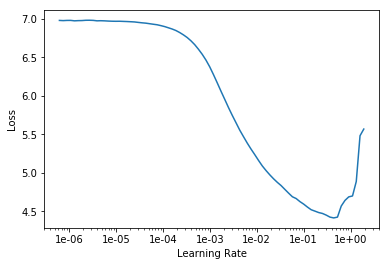

In [36]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.909368,1.862717,0.310917,08:38
1,1.642054,1.573153,0.426417,00:45
2,1.501500,1.409075,0.498750,00:53
3,1.376604,1.320981,0.517917,00:52
4,1.293721,1.171638,0.581167,00:52
5,1.245958,1.510863,0.538333,00:53
6,1.148535,1.052451,0.628917,00:51
7,1.095792,0.980459,0.651833,00:51
8,1.032498,0.981316,0.664083,00:52
9,1.031724,0.948514,0.668833,00:51


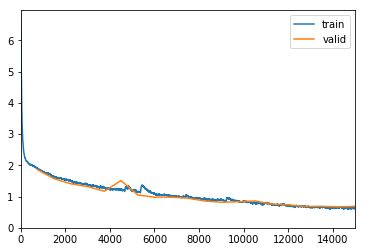

In [37]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(4e-3), wd = 1e-3)
 